In [22]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMNVI.jl")

GMNVI_Run (generic function with 1 method)

## Natural gradient descent

We test natural gradient descent with various quadrature rules on the following problem
## Gaussian mixture
$$
\rho_{\rm post}(\theta) = \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \propto e^{-\Phi_r(\theta)} \qquad
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$

## Circle shape
$$
\rho_{\rm post}(\theta) \propto e^{-\Phi_r(\theta)} \qquad
\Phi_r(\theta) = \frac{(1 - \lVert\theta\rVert^2)^2}{2\sigma_\eta^2} \qquad \sigma_\eta = 0.3
$$

When running the test, you need to manually turn off the adaptive time stepping in GMNVI.jl

In [23]:
function log_Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])))/det(inv_sqrt_x_cov[im])
    end
    return log(ρ) - N_x/2*log(2*π)
end


function Gaussian_mixture_dPhi(θ, args)
    return -log_Gaussian_mixture(θ, args), 
           -ForwardDiff.gradient(x -> log_Gaussian_mixture(x, args), θ), 
           -ForwardDiff.hessian(x -> log_Gaussian_mixture(x, args), θ)
end


function log_circle_shape(x, args)
    # C = L L.T
    # C^-1 = L^-TL^-1
    # return -(1 - x[1]^2 - 4*x[2]^2 - 2*x[1] * x[2])^2/(2 * 0.5^2)
    return -(1 - x[1]^2 - x[2]^2)^2/(2 * 0.3^2)
end


function circle_shape_dPhi(θ, args)
    return -log_circle_shape(θ, args), 
           -ForwardDiff.gradient(x -> log_circle_shape(x, args), θ), 
           -ForwardDiff.hessian(x -> log_circle_shape(x, args), θ)
end


function log_double_banana(x, args)
    # C = L L.T
    ση, λ = [0.3; 1.0; 1.0;], 100.0
    y = [log(λ+1); 0.0; 0.0]
    Gx = [log( λ*(x[2] - x[1]^2)^2 + (1 - x[1])^2 ); x[1]; x[2]]
    return -(y - Gx)' * ((y - Gx)./ (2*ση.^2))
end



function double_banana_dPhi(θ, args)
    return -log_double_banana(θ, args), 
           -ForwardDiff.gradient(x -> log_double_banana(x, args), θ), 
           -ForwardDiff.hessian(x -> log_double_banana(x, args), θ)
end

double_banana_dPhi (generic function with 1 method)

In [24]:
function visualization_2d(ax; Nx=2000, Ny=2000, x_lim=[-4.0,4.0], y_lim=[-4.0,4.0], func_Phi = nothing, objs=nothing, label=nothing)

    # visualization 
    x_min, x_max = x_lim
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'   #'

    Z_ref = posterior_2d(func_Phi, X, Y, "func_Phi")
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_obj = length(objs)
    N_iter = length(objs[1].logx_w) - 1
    error = zeros(N_obj, N_iter+1)
        
    for (iobj, obj) in enumerate(objs)
        for iter = 0:N_iter  
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[iobj, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
                    
                ax[1+iobj].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                N_modes = size(x_mean, 1)
                ax[1+iobj].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[1+iobj].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
               
            end
        end
        
    end

    markers = ["o", "s", "^", "v", ">", "<", "D", "p", "*"]
    
    for i_obj = 1:N_obj
        ax[N_obj+2].semilogy(Array(0:N_iter), error[i_obj, :],  label= label[i_obj], marker=markers[i_obj], markevery=div(N_iter,10),markerfacecolor="none")   
   end
    # Get the current y-axis limits
    ymin, ymax = ax[N_obj+2].get_ylim()
    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1
        ax[N_obj+2].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end
   
end

visualization_2d (generic function with 1 method)

[ Info: starting Gaussian mixture test
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: (

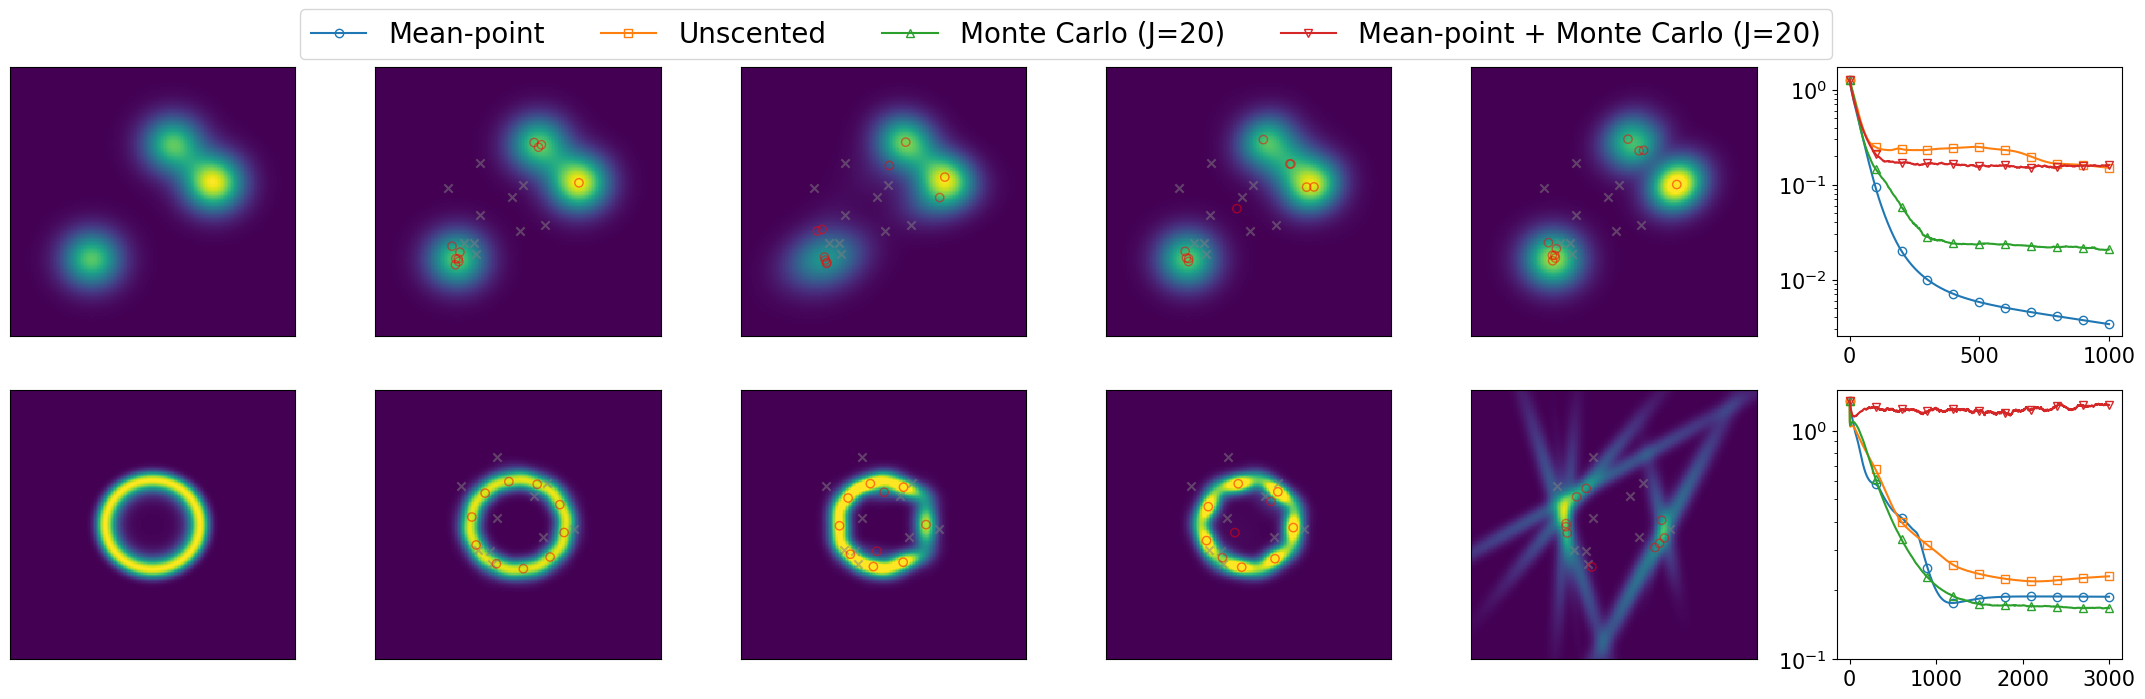

In [27]:
fig, ax = PyPlot.subplots(nrows=2, ncols=6, sharex=false, sharey=false, figsize=(22,8))


Random.seed!(111);
N_modes = 10
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end





sqrt_matrix_type = "Cholesky"
quadrature_test_list = [
    ("mean_point","mean_point", 1),
    ("unscented_transform","unscented_transform", 5),
    ("random_sampling","random_sampling", 20),
    ("random_sampling","mean_point", 20)
    ]



###### Gaussian mixture
@info "starting Gaussian mixture test"
x_w_ref, x_mean_ref = [0.3;0.4;0.3], [1.0 2.0; 2.0 1.0; -1.0 -1.0]
N_modes_ref, N_x = size(x_mean_ref)
xx_cov_ref = zeros(N_modes_ref, 2, 2)
for im = 1:N_modes_ref
    xx_cov_ref[im,:,:] += I/4
end

inv_sqrt_x_cov_ref = [compute_sqrt_matrix(xx_cov_ref[im,:,:]; type="Cholesky")[2] for im = 1:N_modes_ref]
func_args = (x_w_ref, x_mean_ref, inv_sqrt_x_cov_ref)
func_dPhi(x) = Gaussian_mixture_dPhi(x, func_args)
func_Phi(x) = -log_Gaussian_mixture(x, func_args)

N_iter   = 1000
dt = 0.03  #0.03
T =  N_iter * dt
objs = [GMNVI_Run(func_dPhi, T, N_iter, x0_w, x0_mean, xx0_cov; 
                quadrature_type_GM = quadrature_type_GM,  quadrature_type = quadrature_type, c_weight_GM = 3.0, c_weight = 3.0, N_ens_GM = N_ens, N_ens = N_ens, Hessian_correct_GM = false, diagonal_covariance=false) for  (quadrature_type_GM, quadrature_type, N_ens) in quadrature_test_list]
visualization_2d(ax[1,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 4.0], y_lim=[-3.0, 4.0], func_Phi = func_Phi, objs=objs, 
        label=["Mean-point",   "Unscented",   "Monte Carlo (J=20)", "Mean-point + Monte Carlo (J=20)"])
for i = 1:size(ax,2) - 1
    ax[1,i].get_xaxis().set_visible(false)
    ax[1,i].get_yaxis().set_visible(false)
end


###### Circle 
@info "starting circle test"
func_dPhi(x) = circle_shape_dPhi(x, nothing)
func_Phi(x) = -log_circle_shape(x, nothing)
N_iter   = 3000
dt = 6e-3  #7e-3
T =  N_iter * dt
objs = [GMNVI_Run(func_dPhi, T, N_iter, x0_w, x0_mean, xx0_cov; 
                quadrature_type_GM = quadrature_type_GM,  quadrature_type = quadrature_type, c_weight_GM = 3.0, c_weight = 3.0, N_ens_GM = N_ens, N_ens = N_ens, Hessian_correct_GM = false, diagonal_covariance=false) for  (quadrature_type_GM, quadrature_type, N_ens) in quadrature_test_list]
visualization_2d(ax[2,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_Phi = func_Phi, objs=objs, 
        label=["Mean-point",   "Unscented",   "Monte Carlo (J=20)", "Mean-point + Monte Carlo (J=20)"])

for i = 1:size(ax,2) - 1
    ax[2,i].get_xaxis().set_visible(false)
    ax[2,i].get_yaxis().set_visible(false)
end


###### Double banana, this test requires an extremely small dt for the Monte Carlo method
# @info "starting double banana test"
# func_dPhi(x) = double_banana_dPhi(x, nothing)
# func_Phi(x) = -log_double_banana(x, nothing)
# N_iter   = 1000
# dt = 1e-7   
# T =  N_iter * dt
# objs = [GMNVI_Run(func_dPhi, T, N_iter, x0_w, x0_mean, xx0_cov; 
#                 quadrature_type_GM = quadrature_type_GM,  quadrature_type = quadrature_type, c_weight_GM = 3.0, c_weight = 3.0, N_ens_GM = N_ens, N_ens = N_ens, Hessian_correct_GM = false, diagonal_covariance=false) for  (quadrature_type_GM, quadrature_type, N_ens) in quadrature_test_list]
# visualization_2d(ax[3,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_Phi = func_Phi, objs=objs, 
#         label=["Mean-point",   "Unscented",   "Monte Carlo (J=20)", "Mean-point + Monte Carlo (J=20)"])

# for i = 1:size(ax,2) - 1
#     ax[3,i].get_xaxis().set_visible(false)
#     ax[3,i].get_yaxis().set_visible(false)
# end


handles, labels = ax[end,end].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=length(quadrature_test_list), fontsize=20)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15,top=0.89,left=0.02,right=0.98,hspace=0.2)

fig.savefig("Quadrature-Points.pdf")